In [21]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm
import json
import ast
import time
from random import uniform
import geopandas as gpd
import folium
from folium import DivIcon
from folium.plugins import FeatureGroupSubGroup
from folium.plugins import MarkerCluster
from collections import defaultdict
import warnings
warnings.simplefilter("ignore")
import pycountry
import seaborn as sns
import plotly.express as px
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from collections import Counter

In [ ]:
## Data Retrieval for Top-Rated 500 Movies

In [3]:
# Read API Key
f = open('TMDB API Read Access Key.txt','r')
api_tmdb_key = f.read()
url_template = "https://api.themoviedb.org/3/movie/top_rated?language=en-US&page={page}"
headers = {
    "accept": "application/json",
    "Authorization": api_tmdb_key,
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
}

In [4]:
movies = []

# Loop through each genre and fetch Top 500 movies (25 pages x 20 movies)
for page in range(1, 26):
    try:
        response = requests.get(url_template.format(page=page), headers=headers)
        data = response.json()
        results = data.get('results', [])

        # Extract key information
        for movie in results:
            movies.append({
                'id': movie['id'],
                'title': movie['title'],
                'genre_ids': movie['genre_ids'],
                'vote_count': movie['vote_count'],
                'rating': movie['vote_average']
                
            })

        # Control request frequency to prevent blocking
        time.sleep(uniform(0.5, 1.0))

    except Exception as e:
        print(f"Failed request (Page {page}): {e}")
        time.sleep(5)  # Delay 5 seconds before retrying

# Convert to DataFrame
movies_df = pd.DataFrame(movies)

In [ ]:
## Data Retrieval for Top-Rated 200 Movies by Genre

In [22]:
genre_url = "https://api.themoviedb.org/3/discover/movie"

In [23]:
# Genre ID Mapping
genre_dict = {
    "Action": 28, "Adventure": 12, "Animation": 16,
    "Comedy": 35, "Crime": 80, "Documentary": 99,
    "Drama": 18, "Family": 10751, "Fantasy": 14,
    "History": 36, "Horror": 27, "Music": 10402, 
    "Mystery": 9648, "Romance": 10749, "Sci-Fi": 878,
    "Thriller": 53, "War": 10752
}

In [7]:
# Movie data storage
genre_movies = []

# Read API Token
f = open('TMDB API Read Access Token.txt','r')
api_tmdb_token = f.read()

# Loop through each genre and fetch Top 200 movies (10 pages x 20 movies)
for genre, genre_id in genre_dict.items():
    for page in range(1, 11):
        try:
            # API request with params
            params = {
                'api_key': api_tmdb_token,
                'with_genres': genre_id,
                'sort_by': 'vote_average.desc',
                'vote_count.gte': 300,
                'page': page
            }

            genre_response = requests.get(genre_url, params=params)
            genre_data = genre_response.json()
            genre_results = genre_data.get('results', [])

            # Extract important information
            for movie in genre_results:
                genre_movies.append({
                    'genre': genre,
                    'id': movie['id'],
                    'title': movie['title'],
                    'rating': movie['vote_average']
                })

            # Random delay to prevent rate limits
            time.sleep(uniform(0.5, 1.0))

        except Exception as e:
            print(f"Failed to fetch data (Genre: {genre}, Page: {page}): {e}")
            time.sleep(5)  # Delay 5 seconds before retrying

# Convert data to DataFrame
genre_movies_df = pd.DataFrame(genre_movies)

In [9]:
# Initialize list
budgets = []
revenues = []
production_countries = []
imdb_ids = []

# Retrieve IMDb ID for each movie
for movie_id in genre_movies_df['id']:
    try:
        response2 = requests.get(f'https://api.themoviedb.org/3/movie/{movie_id}?language=en-US', headers=headers)
        data2 = response2.json()
    
        # Store the key information in the list
        budgets.append(data2['budget'])
        revenues.append(data2['revenue'])
        try:
            production_countries.append([country['iso_3166_1'] for country in data2['production_countries']])
        except Exception as e:
            production_countries.append(None)
        imdb_ids.append(data2['imdb_id'])
    
    except Exception as e:
        print(f"Failed to fetch data for Movie ID {movie_id}: {e}")
        budgets.append(None)
        revenues.append(None)
        production_countries.append(None)
        imdb_ids.append(None)
        
    # Avoid to reach the rate limit
    time.sleep(0.05)
    
# Add the detailed information to the dataframe
genre_movies_df['budget'] = budgets
genre_movies_df['revenue'] = revenues
genre_movies_df['production_countries'] = production_countries
genre_movies_df['imdb_ids'] = imdb_ids  

In [10]:
movies_df.to_csv('movies_df.csv', index=False, encoding='utf-8-sig')

In [11]:
genre_movies_df.to_csv('genre_movies_df.csv', index=False, encoding='utf-8-sig')

In [24]:
genre_movies_df = pd.read_csv('genre_movies_df.csv', encoding='utf-8-sig')

In [50]:
movies_df = pd.read_csv('movies_df.csv', encoding='utf-8-sig')

In [ ]:
## Text Frequency Analysis for Top rated 200 movies on each genres

In [ ]:
# Read OMDb API Key
f = open('OMDB API Read Access Key.txt','r')
api_omdb_key = f.read()

# Retrieve IMDb plots for each movie
plots = []
for imdb_id in genre_movies_df['imdb_ids']:
    try:
        response3 = requests.get(f'http://www.omdbapi.com/?i={imdb_id}&apikey={api_omdb_key}')
        data3 = response3.json()
        plots.append(data3['Plot'])
    except Exception as e:
        print(f"Failed to fetch data for Movie ID {imdb_id}: {e}")
        plots.append(None)
    
    # Avoid to reach the rate limit
    time.sleep(0.1)

genre_movies_df['Plot'] = plots

# Store it as the csv file
genre_movies_df.to_csv('genre_movies_df_omdb.csv', index=False, encoding='utf-8-sig')

In [37]:
genres_movies_df = pd.read_csv('genre_movies_df_omdb.csv', encoding='utf-8-sig')

In [27]:
# Identified the number of top words appeared
most_common_words_shown = 15

In [28]:
# Define function to preprocess text (removing stopwords, punctuation, etc.)
def preprocess_text(text):
    
    # Avoid None type introduction
    if text is None:
        return None
    
    # Tokenize the text
    words = word_tokenize(text.lower())
    
    # Remove punctuation and stopwords
    words = [word for word in words if word.isalpha()]  # Keep only alphabetic words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    return words

# Function to analyze word frequency by genre
def genre_word_frequency(df):
    genre_word_freq = {}
    overall_words = []
    
    # Loop through each genre
    for genre in df['genre'].unique():
        # Get all plots for the current genre
        genre_plots = df[df['genre'] == genre]['Plot']
        
        # Preprocess and combine all plots for this genre
        words = []
        for plot in genre_plots:
            plot = str(plot)
            if plot is not None:
                temp = preprocess_text(plot)
                words += temp
                overall_words += temp
        
        # Count the frequency of each word
        word_freq = Counter(words)
        genre_word_freq[genre] = word_freq.most_common(most_common_words_shown)  # Get top x words by frequency
        
        # Count the overall word frequency
        overall_word_freq = Counter(overall_words)
    
    return genre_word_freq, overall_word_freq.most_common(most_common_words_shown)

In [29]:
# Perform the analysis
genre_result, overall_result = genre_word_frequency(genres_movies_df)

# Output the word frequencies for each genre
for genre, word_freq in genre_result.items():
    print(f"Top words in {genre} genre:")
    for word, freq in word_freq:
        print(f"{word}: {freq}")
    print("\n")

# Output the overall word frequencies across all genres
print("Top words overall across all genres:")
for word, freq in overall_result:
    print(f"{word}: {freq}")

Top words in Action genre:
must: 27
new: 20
world: 19
two: 18
save: 16
one: 15
help: 14
team: 14
city: 13
family: 13
find: 13
young: 13
finds: 12
man: 12
life: 11


Top words in Adventure genre:
world: 27
young: 23
must: 22
new: 21
two: 15
team: 14
save: 14
find: 13
family: 13
story: 13
help: 12
finds: 11
war: 11
boy: 11
father: 11


Top words in Animation genre:
young: 36
new: 26
girl: 23
world: 22
boy: 21
two: 17
life: 16
save: 16
family: 15
must: 15
city: 14
find: 14
friends: 14
love: 14
journey: 11


Top words in Comedy genre:
love: 22
new: 21
two: 21
young: 20
life: 19
man: 16
friends: 16
must: 16
family: 14
get: 11
girl: 11
one: 10
friend: 10
woman: 10
home: 10


Top words in Crime genre:
two: 24
young: 24
life: 23
murder: 21
police: 20
crime: 19
one: 19
man: 17
must: 15
family: 13
detective: 13
son: 12
new: 12
city: 11
becomes: 11


Top words in Documentary genre:
documentary: 34
world: 24
life: 17
look: 16
film: 13
footage: 13
one: 11
story: 11
filmmaker: 9
years: 7
new: 7
foll

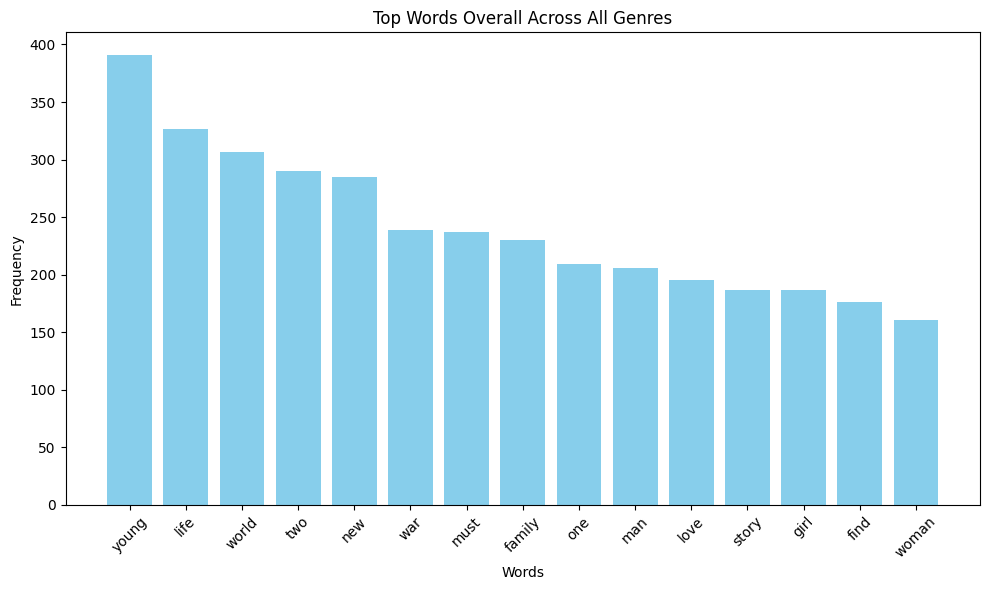

In [58]:
# Separate words and their frequencies
words = [word for word, freq in overall_result]
frequencies = [freq for word, freq in overall_result]

# Create a column plot for the top words overall
plt.figure(figsize=(10, 6))
plt.bar(words, frequencies, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top Words Overall Across All Genres')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
## Exploratory Data Analysis

In [51]:
# Ensure 'budget' and 'revenue' are numeric
movies_df["budget"] = pd.to_numeric(movies_df["budget"], errors="coerce")
movies_df["revenue"] = pd.to_numeric(movies_df["revenue"], errors="coerce")

# Remove rows where 'budget' or 'revenue' is 0 or missing
df_filtered = movies_df[(movies_df["budget"] > 0) & (movies_df["revenue"] > 0)].copy()

# Calculate profit and add a new column
df_filtered["profit"] = df_filtered["revenue"] - df_filtered["budget"]

# Calculate Return on Investment (ROI) and add a new column
df_filtered["ROI"] = df_filtered["profit"] / df_filtered["budget"]

# Function to convert country codes to standard country names
def get_country_name(country_code):
    try:
        country_name = pycountry.countries.lookup(country_code.strip()).name
        if country_name == "Türkiye":  # Fix encoding issue
            return "Turkey"
        return country_name
    except LookupError:
        return None

# Clean and process the 'production_countries' column
df_filtered["production_countries"] = (
    df_filtered["production_countries"]
    .str.strip("[]")
    .str.replace("'", "")
    .str.replace("SU", "RU")  # Convert Soviet Union code to Russia
)

# Split multiple countries and expand into separate rows
df_exploded = df_filtered.assign(
    production_countries=df_filtered["production_countries"].str.split(", ")
).explode("production_countries")

# Convert country codes to full country names
df_exploded["country_name"] = df_exploded["production_countries"].apply(get_country_name)

# Save the cleaned data
final_file_path = "movies_df_final.csv"
#df_exploded.to_csv(final_file_path, index=False)

# Calculate the average profit per country
region_avg_profit = df_exploded.groupby("country_name")["profit"].mean().nlargest(10)

# Calculate the average ROI per country
region_avg_roi = df_exploded.groupby("country_name")["ROI"].mean().nlargest(10)

# Display updated unique country values
unique_countries_updated = df_exploded["country_name"].unique()

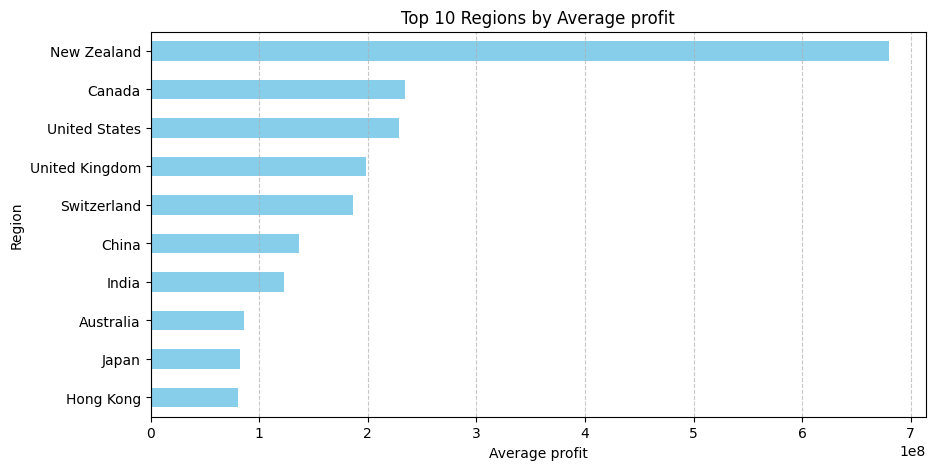

In [52]:
# Plot the top 5 regions by average profit
plt.figure(figsize=(10, 5))
region_avg_profit.sort_values().plot(kind="barh", color="skyblue")
plt.xlabel("Average profit")
plt.ylabel("Region")
plt.title("Top 10 Regions by Average profit")
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Save the chart to a local file
plt.savefig("top_10_regions_avg_profit.png", dpi=300, bbox_inches="tight")
plt.show()

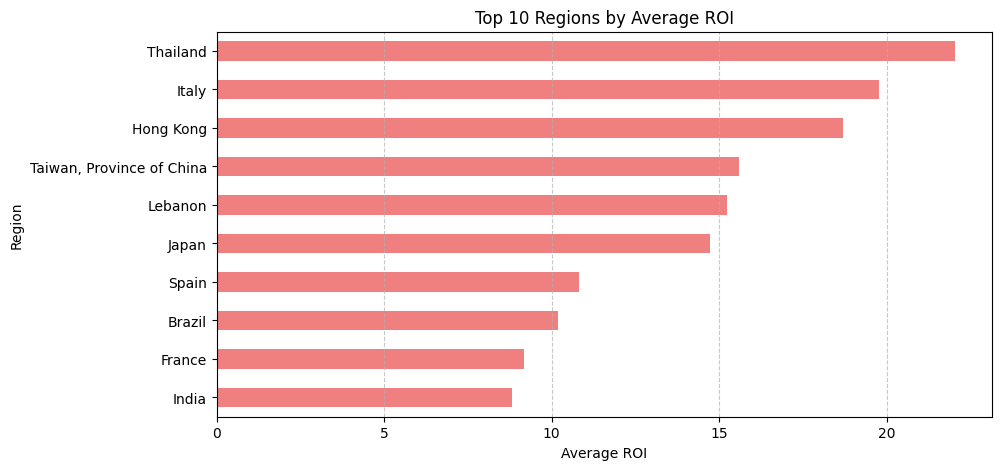

In [53]:
# Plot a horizontal bar chart for the top 5 regions by average ROI
plt.figure(figsize=(10, 5))
region_avg_roi.sort_values().plot(kind="barh", color="lightcoral")
plt.xlabel("Average ROI")
plt.ylabel("Region")
plt.title("Top 10 Regions by Average ROI")
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Save the chart to a local file
plt.savefig("top_10_regions_avg_ROI.png", dpi=300, bbox_inches="tight")
plt.show()


In [54]:
# Read the cleaned CSV file
file_path = "movies_df_final.csv"
df = pd.read_csv(file_path)

# Ensure necessary columns are numeric
df["budget"] = pd.to_numeric(df["budget"], errors="coerce")
df["revenue"] = pd.to_numeric(df["revenue"], errors="coerce")
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")  # Using TMDB rating
df["ROI"] = (df["revenue"] - df["budget"]) / df["budget"]

# Drop rows with missing values in key columns
df = df.dropna(subset=["budget", "revenue", "rating", "ROI"])

# Split multiple genres and expand into separate rows
df["genre_ids"] = df["genre_ids"].str.strip("[]").str.replace("'", "").str.split(", ")
df_exploded = df.explode("genre_ids")


In [55]:
# Verify correct column names
hover_columns = ["title", "genre"]  # Adjust based on actual column names

# Plot 1: Interactive TMDB Ratings vs ROI (Colored by Country)
fig_roi = px.scatter(df, x="rating", y="ROI", color="country_name",
                     title="TMDB Ratings vs ROI (Colored by Country)",
                     labels={"rating": "TMDB Rating", "ROI": "Return on Investment (ROI)"},
                     hover_data=[col for col in hover_columns if col in df.columns],  # Ensure valid columns
                     opacity=0.6)

fig_roi.update_layout(legend_title="Country", xaxis=dict(title="TMDB Rating"), yaxis=dict(title="ROI"))
# Save the plot to a local file
fig_roi.write_html("tmdb_ratings_vs_ROI.html")


# Plot 2: Interactive TMDB Ratings vs profit (Colored by Country, Log Scale)
fig_profit = px.scatter(df, x="rating", y="profit", color="country_name",
                         title="TMDB Ratings vs profit (Colored by Country)",
                         labels={"rating": "TMDB Rating", "profit": "profit ($)"},
                         hover_data=[col for col in hover_columns if col in df.columns],  # Ensure valid columns
                         opacity=0.6)

fig_profit.update_layout(legend_title="Country", xaxis=dict(title="TMDB Rating"), 
                          yaxis=dict(title="Profit ($, Log Scale)"), yaxis_type="log")

# Save the plot to a local file
fig_profit.write_html("tmdb_ratings_vs_profit.html")

# Show the interactive plots
fig_roi.show()
fig_profit.show()


In [ ]:
## Map for Top rated 500

In [56]:
# Clean data for counting production countries
movies_df['production_countries'] = movies_df['production_countries'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Mapping outdated country codes
replacement_dict = {
    'SU': 'RU',   # Soviet Union → Russia
    'YU': 'RS',   # Yugoslavia → Serbia
    'XG': 'DE'    # West Germany → Germany
}

# Aggregate movie counts for each country
country_counts = defaultdict(int)

for idx, row in movies_df.iterrows():
    for country in row['production_countries']:
        # Handle special country codes directly
        if country in replacement_dict:
            country_counts[replacement_dict[country]] += 1  # Add count to correct country
        elif country == 'XC':  
            # Czechoslovakia → Add count to BOTH Czechia and Slovakia
            country_counts['CZ'] += 1
            country_counts['SK'] += 1
        else:
            country_counts[country] += 1  # Standard countries

# Convert country_counts to DataFrame
country_df = pd.DataFrame(list(country_counts.items()), columns=['country', 'count'])

In [ ]:
# Load World Map Data (GeoPandas built-in dataset)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [7]:
# Fetch countries data from REST Countries API
geo1_url = "https://restcountries.com/v3.1/all"
geo1_response = requests.get(geo1_url)
geo1_data = geo1_response.json()

# Extract country information
country_data_1 = []
for country in geo1_data:
    iso_code = country['cca2']  # ISO Alpha-2 code
    cca3 = country['cca3'] # ISO Alpha-3 code

for country in geo1_data:
    country_data_1.append({
        'country': country['name']['common'], # country name
        'cca2': country['cca2'],   # ISO Alpha-2 Code
        'cca3': country['cca3']    # ISO Alpha-3 Code
    })

# Convert to DataFrame
country_data_1_df = pd.DataFrame(country_data_1)

# Create a mapping dictionary for cca2 to full country name
country_mapping = dict(zip(country_data_1_df['cca2'], country_data_1_df['country']))

# Replace `cca2` codes in `country_df` with country names
country_df['country'] = country_df['country'].replace(country_mapping)

In [8]:
# Check which country names in country_df do not exist in GeoPandas
missing_countries = set(country_df['country']) - set(world['name'])
missing_countries

{'Hong Kong', 'United States'}

In [9]:
# Correct Country Name Mapping
# Replace 'United States' → 'United States of America'
# Replace 'Hong Kong' → 'China' (GeoPandas groups Hong Kong under China)
country_df['country'] = country_df['country'].replace({
    'United States': 'United States of America',
    'Hong Kong': 'China'
})

In [10]:
# Merge Data with GeoPandas World Map
merged = world.merge(country_df, left_on='name', right_on='country', how='left')

# Custom Bin Settings
max_count = merged['count'].max()
bins = np.geomspace(1, max_count, num=6).tolist()  # 6 bins using logarithmic scaling
merged['count_bins'] = pd.cut(merged['count'], bins=bins, labels=False)

<Axes: >

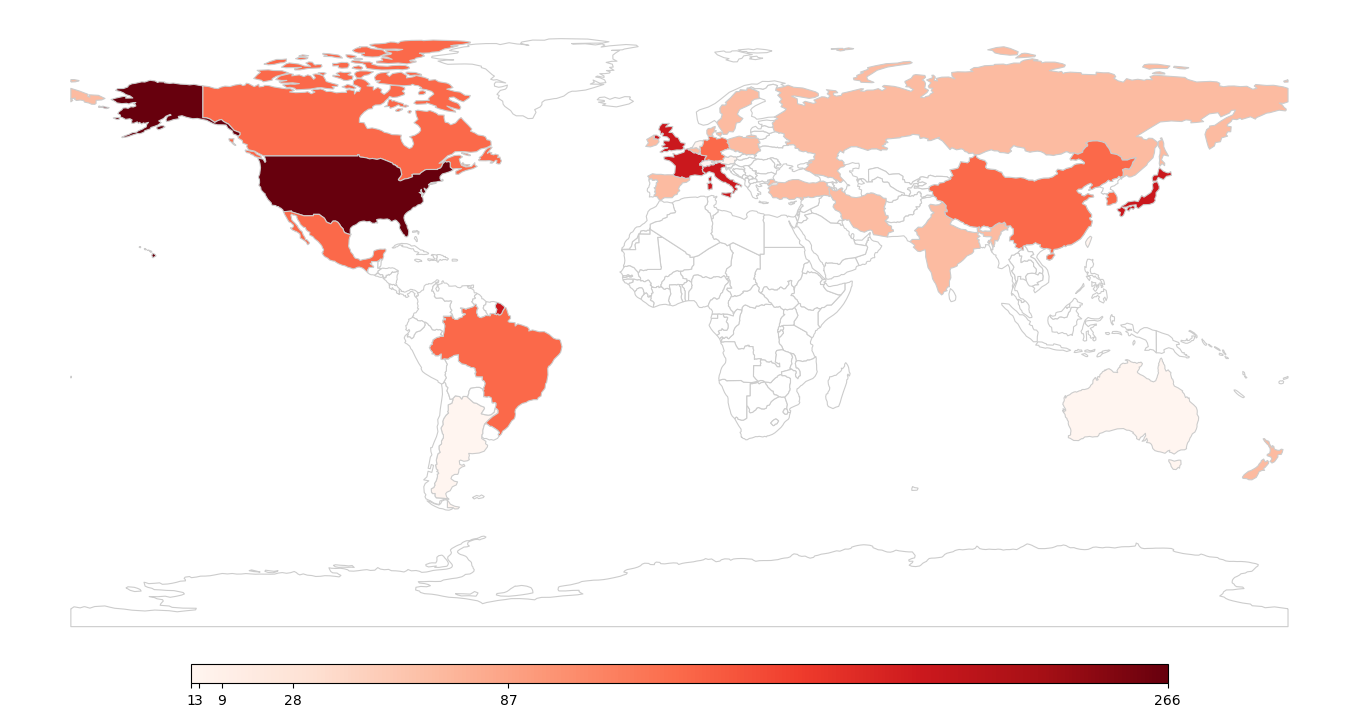

In [11]:
# Create static choropleth map
fig, ax = plt.subplots(1, 1, figsize=(18, 10))
ax.axis("off")  # Hide axis

# Custom Legend with Bin Values
norm = Normalize(vmin=1, vmax=max_count)  # Scale legend using original counts
sm = cm.ScalarMappable(cmap='Reds', norm=norm)
sm._A = []  # Required for colorbar

# Custom Legend with Bin Values
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', shrink=0.7, aspect=50, pad=0.01)
cbar.set_ticks(bins)  # Display bin edges
cbar.ax.set_xticklabels([f"{int(val)}" for val in bins])  # Custom labels for clarity

merged.plot(column='count_bins',
            cmap='Reds',  # Color scheme
            linewidth=0.8,  # Border thickness
            ax=ax,
            edgecolor='0.8',  # Border color
            legend=False,
            missing_kwds={"color": "white", "label": "No data"}
            )

In [ ]:
## Interactive Map for diffenrent genres

In [12]:
# Clean data for movie counting of each genre and country
genre_movies_df['production_countries'] = genre_movies_df['production_countries'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Aggregate movie counts for each country in each genre
country_counts = defaultdict(lambda: defaultdict(int))

for idx, row in genre_movies_df.iterrows():
    genre = row['genre']
    for country in row['production_countries']:
        country_counts[country][genre] += 1

# Convert country_counts to DataFrame
map_data = []
for country, genres in country_counts.items():
    for genre, count in genres.items():
        map_data.append({'country': country, 'genre': genre, 'count': count})

map_df = pd.DataFrame(map_data)

In [ ]:
# Mapping outdated country codes to modern ones
for old_code, new_code in replacement_dict.items():
    for index, row in map_df[map_df['country'] == old_code].iterrows():
        genre = row['genre']
        count = row['count']
        
        # Add the count to the new country
        map_df.loc[(map_df['country'] == new_code) & (map_df['genre'] == genre), 'count'] += count

# Handle 'XC' (Czechoslovakia) by adding counts to BOTH 'CZ' and 'SK'
xc_data = map_df[map_df['country'] == 'XC'].copy()

for index, row in xc_data.iterrows():
    genre = row['genre']
    count = row['count']

    # Add 'count' to Czechia (CZ)
    map_df.loc[(map_df['country'] == 'CZ') & (map_df['genre'] == genre), 'count'] += count

    # Add 'count' to Slovakia (SK)
    map_df.loc[(map_df['country'] == 'SK') & (map_df['genre'] == genre), 'count'] += count

# Remove the original 'SU', 'YU', 'XG', and 'XC' entries
map_df = map_df[~map_df['country'].isin(['SU', 'YU', 'XG', 'XC'])]

In [16]:
# Merge DataFrames on 'cca2' (ISO Alpha-2 Code)
country_data_2 = pd.merge(map_df, country_data_1_df, left_on='country', right_on='cca2', how='left')
country_data_2.drop('cca2', axis=1, inplace=True)
country_data_2.rename(columns={'country_y': 'country'}, inplace=True)
country_data_2.rename(columns={'country_x': 'cca2'}, inplace=True)
column_order = ['country', 'cca2', 'cca3'] + [col for col in country_data_2.columns if col not in ['country', 'cca2', 'cca3']]
country_data_2 = country_data_2[column_order]

In [18]:
# Load GeoJSON Data for countries
geo_url = "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json"
geo_data = requests.get(geo_url).json()

# Aggregate data by country and genre for mapping
agg_data = country_data_2.groupby(['cca3', 'genre']).agg({'count': 'sum'}).reset_index()

In [19]:
# Create a Folium Map
genre_map = folium.Map(location=[20, 0], zoom_start=2)

# Define Genre-Specific Color Scales
genre_colors = {
    "Action": 'Reds',          # Light Red → Dark Red
    "Adventure": 'Blues',      # Light Blue → Dark Blue
    "Animation": 'Greens',     # Light Green → Dark Green
    "Comedy": 'YlGn',          # Light Yellow-Green → Dark Green
    "Crime": 'Oranges',        # Light Orange → Dark Orange
    "Documentary": 'PuBu',     # Light Purple-Blue → Dark Blue
    "Drama": 'PuRd',           # Light Purple-Red → Dark Red
    "Family": 'BuPu',          # Light Blue-Purple → Dark Purple
    "Fantasy": 'YlGnBu',       # Light Yellow-Green-Blue → Dark Blue
    "History": 'YlOrBr',       # Light Yellow-Orange-Brown → Dark Brown
    "Horror": 'OrRd',          # Light Orange-Red → Dark Red
    "Music": 'BuGn',           # Light Blue-Green → Dark Green
    "Mystery": 'PuBuGn',       # Light Purple-Blue-Green → Dark Green
    "Romance": 'RdPu',         # Light Red-Purple → Dark Purple
    "Sci-Fi": 'GnBu',          # Light Green-Blue → Dark Blue
    "Thriller": 'YlOrRd',      # Light Yellow-Orange-Red → Dark Red
    "War": 'OrRd'              # Light Orange-Red → Dark Red
}

# Custom Bin Settings
max_count = agg_data['count'].max()
bins = np.geomspace(1, max_count, num=8).tolist()  # Logarithmic scaling for better balance

# Add Choropleth Layers for Each Genre
for genre in agg_data['genre'].unique():
    genre_data = agg_data[agg_data['genre'] == genre]

    folium.Choropleth(
        geo_data=geo_data,
        name=genre,  # Enables toggling in LayerControl
        data=genre_data,
        columns=['cca3', 'count'],
        key_on='feature.id',  # Ensure this matches GeoJSON's country code format
        fill_color=genre_colors.get(genre, 'White'),
        fill_opacity=0.7,
        line_opacity=0.3,
        bins=bins,
        legend_name=f'{genre} Movie Count'
    ).add_to(genre_map)

# Add LayerControl for Better Visualization
folium.LayerControl(collapsed=False).add_to(genre_map)

# Add the Note as a Marker
note_text = """
<div style="font-size:14px; 
            background-color:white; 
            padding:5px 10px; 
            border:2px solid black; 
            border-radius:5px;
            box-shadow: 3px 3px 5px grey;">
    <b>Note:</b> Black areas indicate zero movie count for the genre.
</div>
"""

folium.Marker(
    location=[-30, -170],  # Position for the note
    icon=DivIcon(icon_size=(250, 36), html=note_text)
).add_to(genre_map)

In [20]:
# Display the map
genre_map

In [ ]:
# Save the interactive map as html
genre_map.save("movie_genre_interactive_map.html")